In [745]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

In [746]:
# Load the sound signal (replace 'your_sound_file.wav' with your actual file)
fs, signal_data = wavfile.read('noisy_audio.wav')

# Define the cutoff frequency in Hz (2 kHz in this case)
cutoff_frequency = 2000.0  # 2 kHz

# Calculate the number of taps for the FIR filter (odd number)
num_taps = 511  # You can adjust the number of taps as needed

# Create a time vector for the filter
taps = np.arange(0, num_taps)
n = np.arange(num_taps)

alpha = 0.54
beta = 0.46
hamming_window = alpha - beta * np.cos(2 * np.pi * n / (num_taps - 1))

# Calculate the ideal low-pass filter kernel
ideal_filter = 2 * cutoff_frequency / fs * np.sinc(2 * cutoff_frequency * (taps - (num_taps - 1) / 2) / fs)
ideal_filter = ideal_filter * hamming_window
# Normalize the filter to have a unity gain at DC (0 Hz)
ideal_filter /= np.sum(ideal_filter)

In [747]:
# Apply the filter to the signal using convolution
filtered_signal = np.convolve(signal_data, ideal_filter, mode='same')

# Apply the filter backward
filtered_signal = np.convolve(filtered_signal[::-1], ideal_filter, mode='same')[::-1]

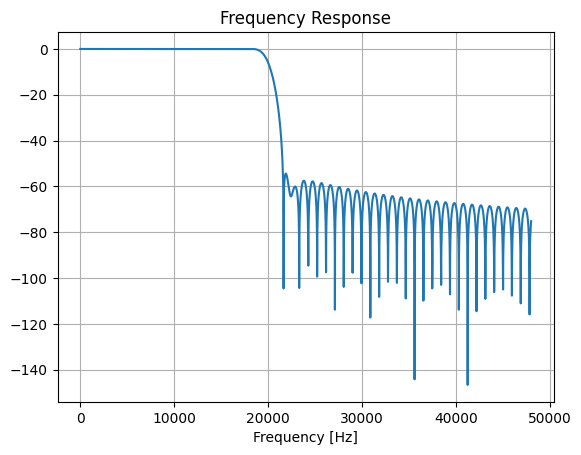

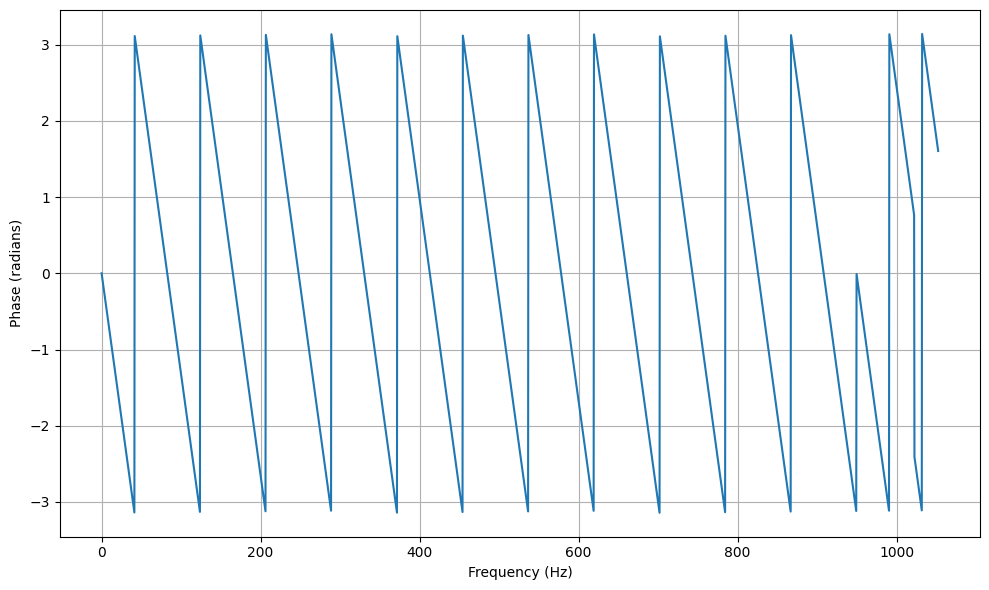

In [748]:
w = np.arange(0, fs , 10)
h = np.fft.fft(ideal_filter, n=fs)
plt.figure()
plt.title('Frequency Response')
plt.plot(w, 20 * np.log10(np.abs(h[:len(w)])))
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

N = len(filtered_signal)
# Compute the frequency axis
freq_axis = np.fft.fftfreq(N, 1/fs)
plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(w)//2], np.angle(h[:len(w)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.grid()

plt.tight_layout()
plt.show()

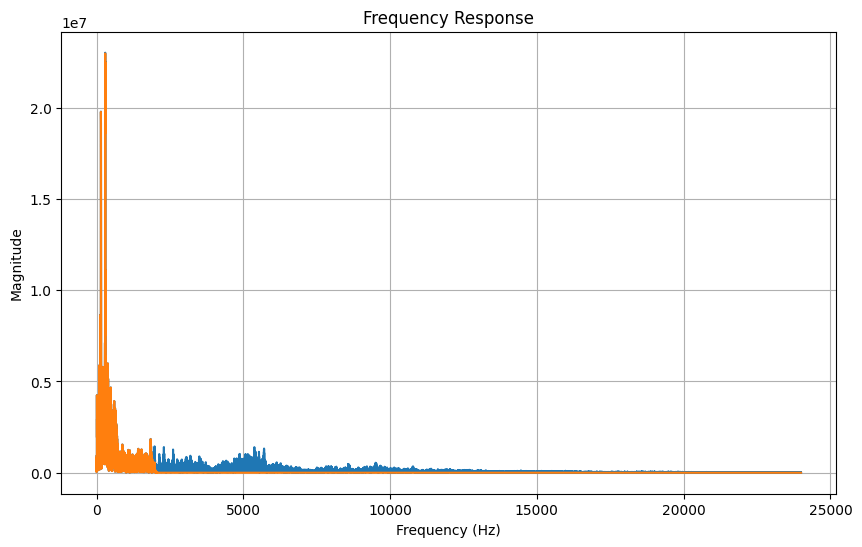

In [749]:
N = len(filtered_signal)
# Compute the frequency axis
freq_axis = np.fft.fftfreq(N, 1/fs)
# Compute the DFT of the filtered signal
fft_result = np.fft.fft(filtered_signal)
fft_result2 = np.fft.fft(signal_data)
# Plot the magnitude response of the filter for positive frequencies
plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:N//2], np.abs(fft_result2[:N//2]))
plt.plot(freq_axis[:N//2], np.abs(fft_result[:N//2]))
plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()

In [750]:
def customspectrogram(signal, fs, window_size=512, overlap=0.75):
    overlap_samples = int(window_size * overlap)
    time_axis = np.arange(0, len(signal), overlap_samples) / fs
    specgram = np.zeros((window_size // 2, len(time_axis)))
    window = np.hamming(window_size)

    for i, start in enumerate(range(0, len(signal) - window_size, overlap_samples)):
        segment = signal[start:start + window_size] * window
        segment_fft = np.fft.fft(segment)[:window_size // 2]
        specgram[:, i] = 10 * np.log10(np.abs(segment_fft)**2)

    return time_axis, specgram

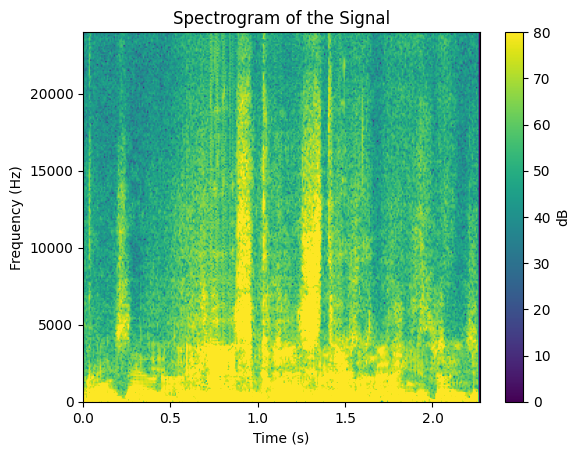

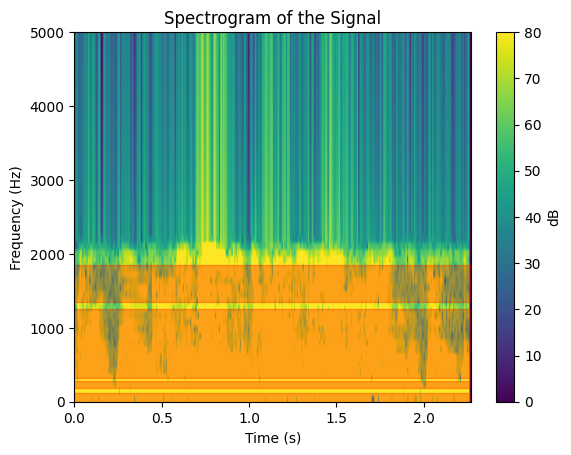

In [751]:
# Define frequency bands
freq_bands = [(0, 120), (180, 280), (320, 1250), (1350, 1850)]

time_axis, specgram = customspectrogram(signal_data, fs)
plt.imshow(specgram, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_axis.min(), time_axis.max(), 0, fs/2],vmin = 0,vmax = 80)
plt.title('Spectrogram of the Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='dB')
plt.show()
# Create and plot the spectrogram
time_axis, specgram = customspectrogram(filtered_signal, fs)
plt.imshow(specgram, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_axis.min(), time_axis.max(), 0, fs/2],vmin = 0, vmax = 80)
plt.title('Spectrogram of the Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,5000)
plt.colorbar(label='dB')
# Mark the specified frequency bands
for band in freq_bands:
    plt.axhspan(band[0], band[1], color='red', alpha=0.3)
plt.show()

In [752]:
wavfile.write('low_pass_audio.wav', fs, filtered_signal.astype(np.int16))

In [753]:
def bandReject_filter(N,fc1,fc2,Fs,org_signal_data):
    # N = 1023
    # [fc1,fc2] = eval(input('Enter the cutoff frequency='))
    # Fs = fs
    FN = 2*fc2    #Nyquist rate


    #Hamming window generation
    # taps = np.arange(0, N)
    n = np.arange(N)
    alpha = 0.54
    beta = 0.46
    wn = alpha - beta * np.cos(2 * np.pi * n / (N - 1))
    
    wc1 = 2*(fc1/Fs)*np.pi
    wc2 = 2*(fc2/Fs)*np.pi
    
    K = 0.8  #gain
    #FIR filter cofficients generated from formula directly
    Tuo = (N-1)/2
    hd  = np.zeros(N)
    h   = np.zeros(N)
    for n in range(N):
        if n==Tuo:
            hd[n] = 1-((wc2-wc1)/np.pi)
            
        else:
            hd[n] = (np.sin(np.pi*(n-Tuo))-(np.sin(wc2*(n-Tuo))-np.sin(wc1*(n-Tuo))))/(np.pi*(n-Tuo))
        h[n] = hd[n]*wn[n]
        #h[n] = h[n] 

    # Apply the filter to the signal using convolution
    filtered_signal = np.convolve(org_signal_data, h, mode='same')
    return filtered_signal,h
    

In [754]:
signal,h1 = bandReject_filter(1023,0,120,fs,filtered_signal)
signal,h2 = bandReject_filter(1023,180,280,fs,signal)
signal,h3 = bandReject_filter(1023,320,1250,fs,signal)
signal,h4 = bandReject_filter(1023,1350,1850,fs,signal)

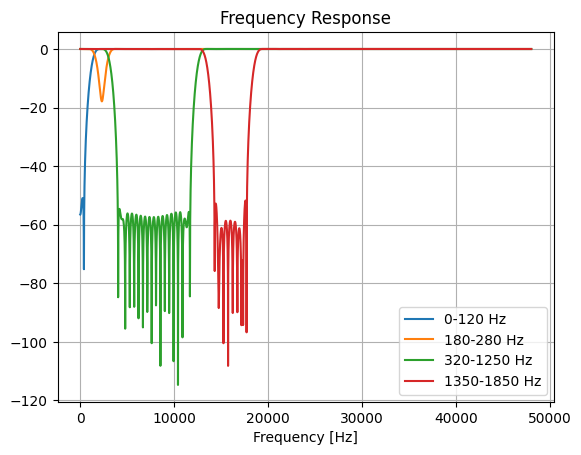

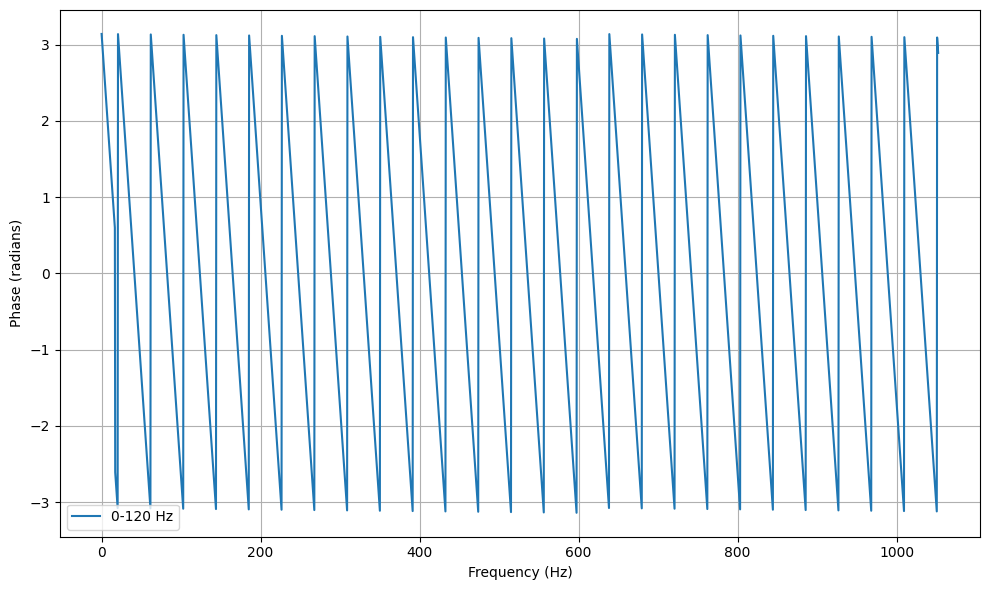

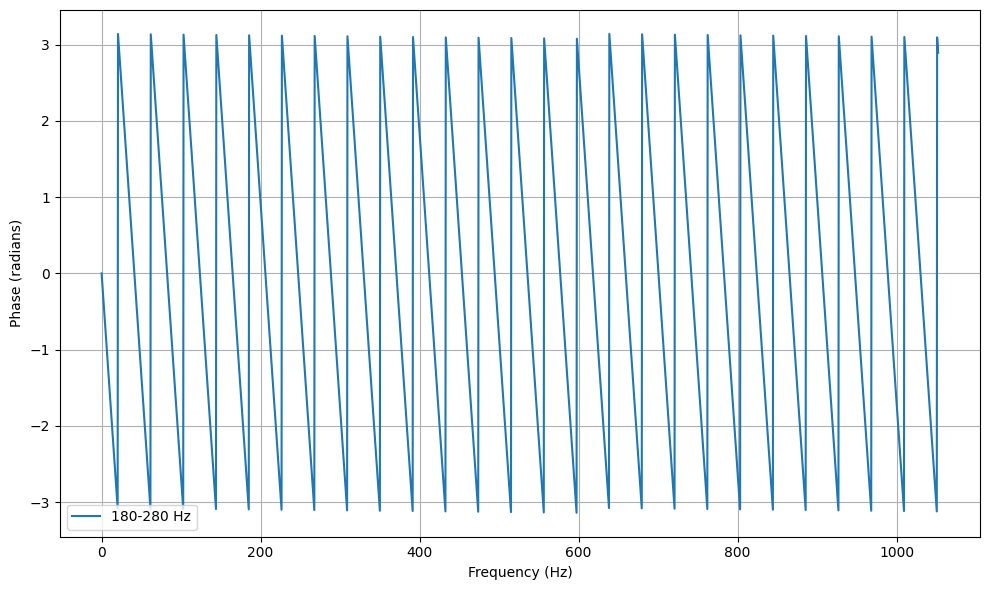

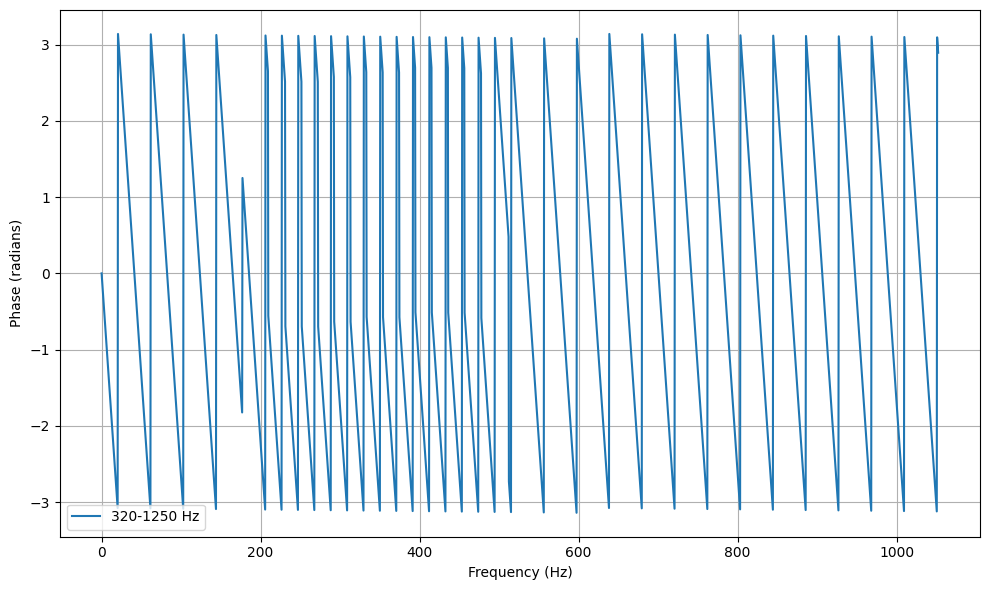

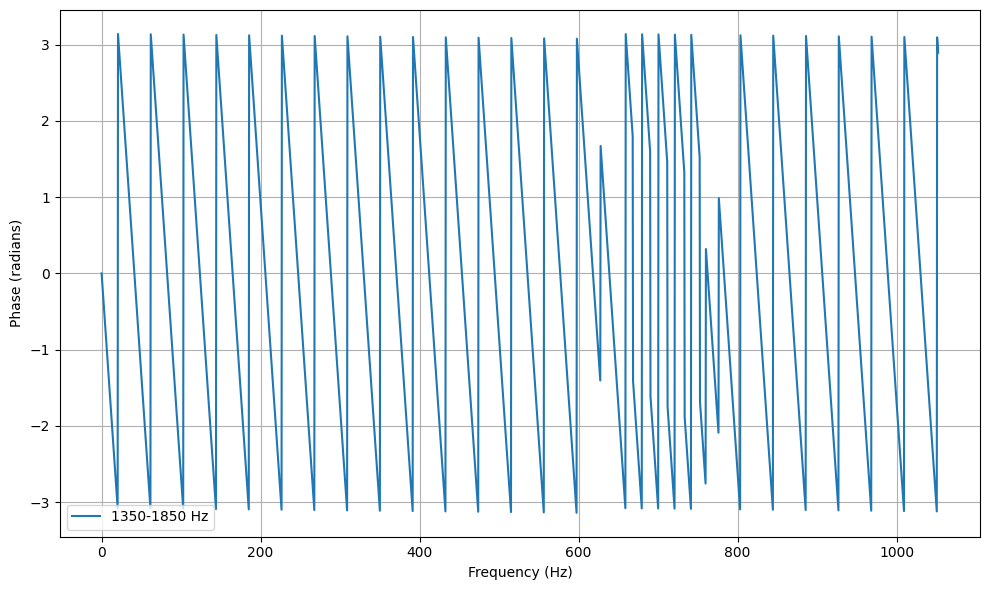

In [755]:
w = np.arange(0, fs , 10)
h1 = np.fft.fft(h1, n=fs)
h2 = np.fft.fft(h2, n=fs)
h3 = np.fft.fft(h3, n=fs)
h4 = np.fft.fft(h4, n=fs)
signal = signal*3
plt.figure()
plt.title('Frequency Response')
plt.plot(w, 20 * np.log10(np.abs(h1[:len(w)])),label = '0-120 Hz')
plt.plot(w, 20 * np.log10(np.abs(h2[:len(w)])),label = '180-280 Hz')
plt.plot(w, 20 * np.log10(np.abs(h3[:len(w)])),label = '320-1250 Hz')
plt.plot(w, 20 * np.log10(np.abs(h4[:len(w)])),label = '1350-1850 Hz')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(w)//2], np.angle(h1[:len(w)//2]),label = '0-120 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(w)//2], np.angle(h2[:len(w)//2]),label = '180-280 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(w)//2], np.angle(h3[:len(w)//2]),label = '320-1250 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(w)//2], np.angle(h4[:len(w)//2]),label = '1350-1850 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [756]:
wavfile.write('final_audio.wav', fs, signal.astype(np.int16))

Text(0, 0.5, 'Magnitude')

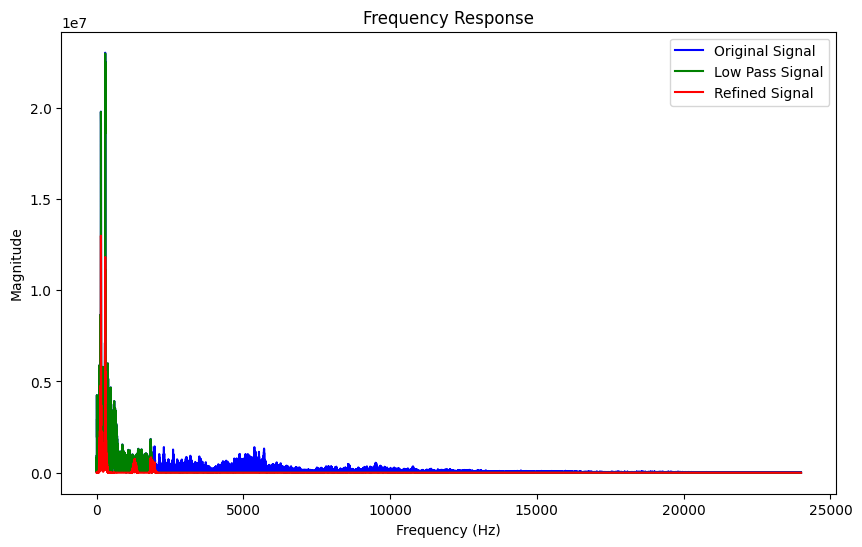

In [757]:
N = len(filtered_signal)
# Compute the frequency axis
freq_axis = np.fft.fftfreq(N, 1/fs)
# Compute the DFT of the filtered signal
signal = signal/3
fft_result = np.fft.fft(signal_data)
fft_result2 = np.fft.fft(filtered_signal)
fft_result3 = np.fft.fft(signal)
# Plot the magnitude response of the filter for positive frequencies
plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:N//2], np.abs(fft_result[:N//2]),color = 'b',label = 'Original Signal')
plt.plot(freq_axis[:N//2], np.abs(fft_result2[:N//2]), color = 'g',label = 'Low Pass Signal')
plt.plot(freq_axis[:N//2], np.abs(fft_result3[:N//2]), color = 'r',label = 'Refined Signal')
plt.title('Frequency Response')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

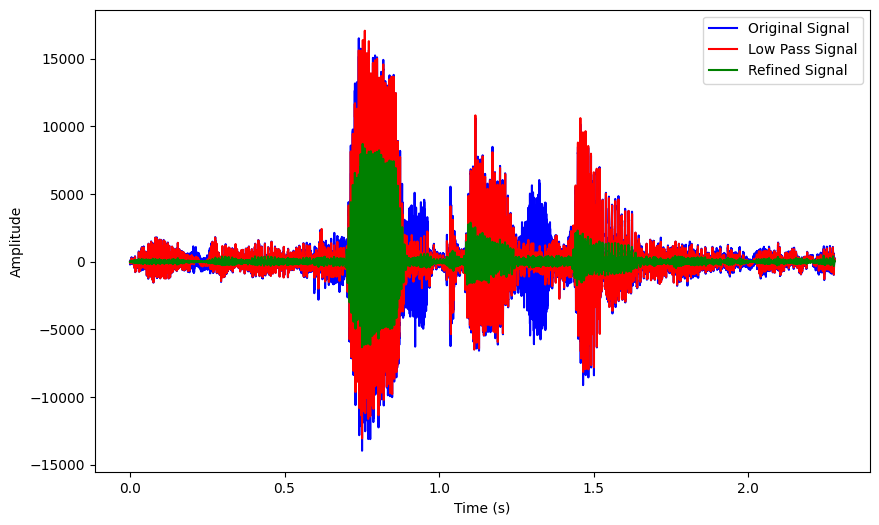

In [758]:
time = np.arange(len(signal_data)) / fs
# Plot the original and filtered signals on the same graph
plt.figure(figsize=(10, 6))
plt.plot(time, signal_data, label='Original Signal', color='b')
plt.plot(time, filtered_signal, label='Low Pass Signal', color='r')
plt.plot(time, signal, label='Refined Signal', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [759]:
a = np.abs(sum((signal_data/len(signal_data) - signal/len(signal_data))**2))
b = np.abs(sum((signal_data/len(signal_data))**2))
print(10 * np.log10(b/a))

3.9649968216285285


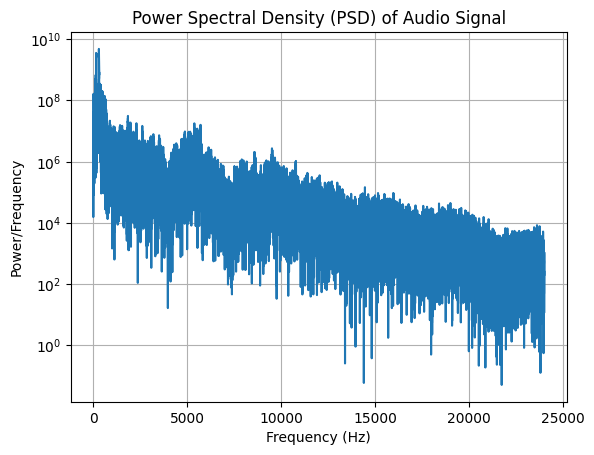

In [760]:
# Compute the one-sided FFT
frequencies = np.fft.fftfreq(len(signal_data), 1/fs)
fft_values = np.fft.fft(signal_data)
magnitude_spectrum = np.abs(fft_values)  # Magnitude spectrum

# Compute the power spectral density
psd = (magnitude_spectrum**2) / len(signal_data)

# Plot the PSD
plt.semilogy(frequencies[:len(frequencies)//2], psd[:len(psd)//2])
plt.title('Power Spectral Density (PSD) of Audio Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.grid(True)
plt.show()

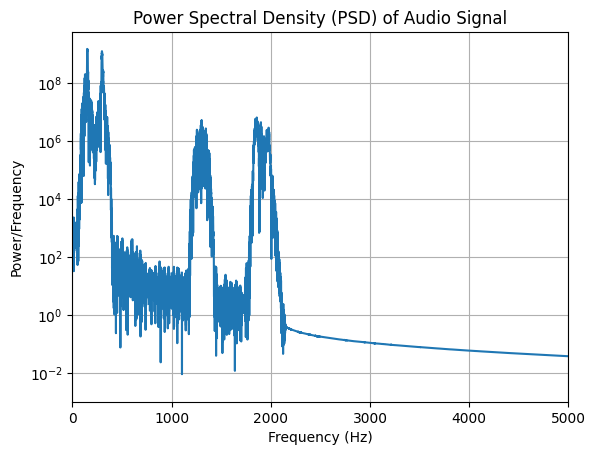

In [761]:
# Compute the one-sided FFT
frequencies = np.fft.fftfreq(len(signal), 1/fs)
fft_values = np.fft.fft(signal)
magnitude_spectrum = np.abs(fft_values)  # Magnitude spectrum

# Compute the power spectral density
psd = (magnitude_spectrum**2) / len(signal)

# Plot the PSD
plt.semilogy(frequencies[:len(frequencies)//2], psd[:len(psd)//2])
plt.title('Power Spectral Density (PSD) of Audio Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.xlim(0,5000)
plt.grid(True)
plt.show()


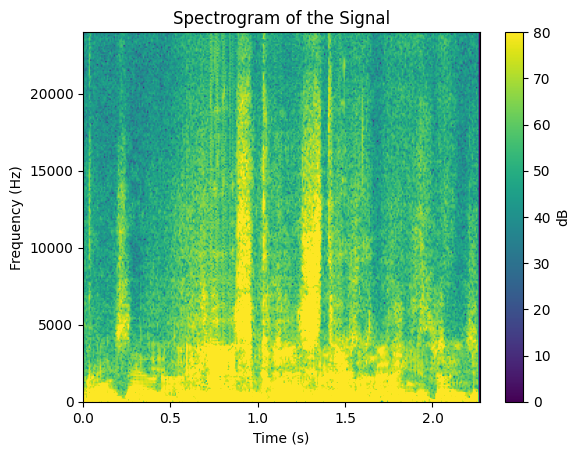

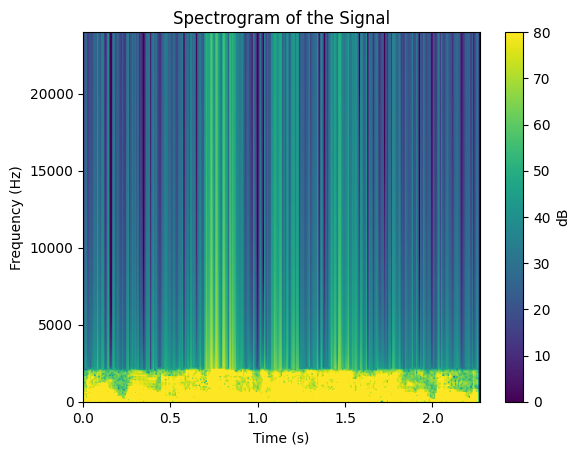

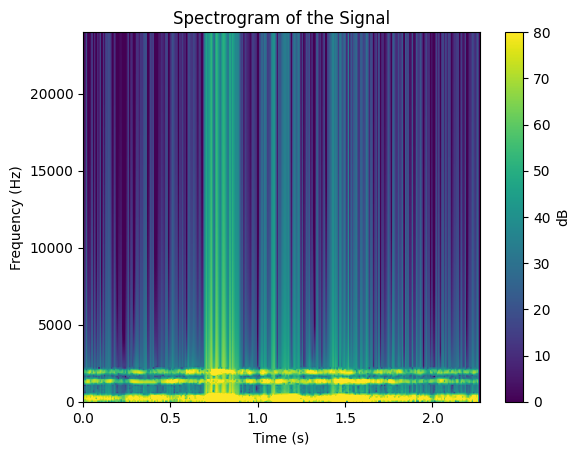

In [762]:
time_axis, specgram = customspectrogram(signal_data, fs)
plt.imshow(specgram, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_axis.min(), time_axis.max(), 0, fs/2],vmin = 0,vmax = 80)
plt.title('Spectrogram of the Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='dB')
plt.show()
time_axis, specgram = customspectrogram(filtered_signal, fs)
plt.imshow(specgram, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_axis.min(), time_axis.max(), 0, fs/2],vmin = 0,vmax = 80)
plt.title('Spectrogram of the Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='dB')
plt.show()
time_axis, specgram = customspectrogram(signal, fs)
plt.imshow(specgram, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_axis.min(), time_axis.max(), 0, fs/2],vmin = 0,vmax = 80)
plt.title('Spectrogram of the Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='dB')
plt.show()